In [1]:
import math
import numpy
import pandas as pd

path = './lichess_2016-09_engineered_df_eco.feather'

df = pd.read_feather(path)
df.head()

White,-ArtanS-,-LEXX-,-chessnoob-,-sayen23-,0203,1--,10H01,1111112222,1taurus,234234,...,zzalimm,zzchess,zzippy,zzoora,zzpp,zztopillo,zzulu,zzxc,zzz___zzz,zzzombie
ECO,,,,,,,,,,,,,,,,,,,,,
A00,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.318584,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.5,0.8,0.0,0.0,0.0,0.0,0.0
A10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, A00 to E60
Columns: 23916 entries, -ArtanS- to zzzombie
dtypes: float32(23916)
memory usage: 5.8+ MB


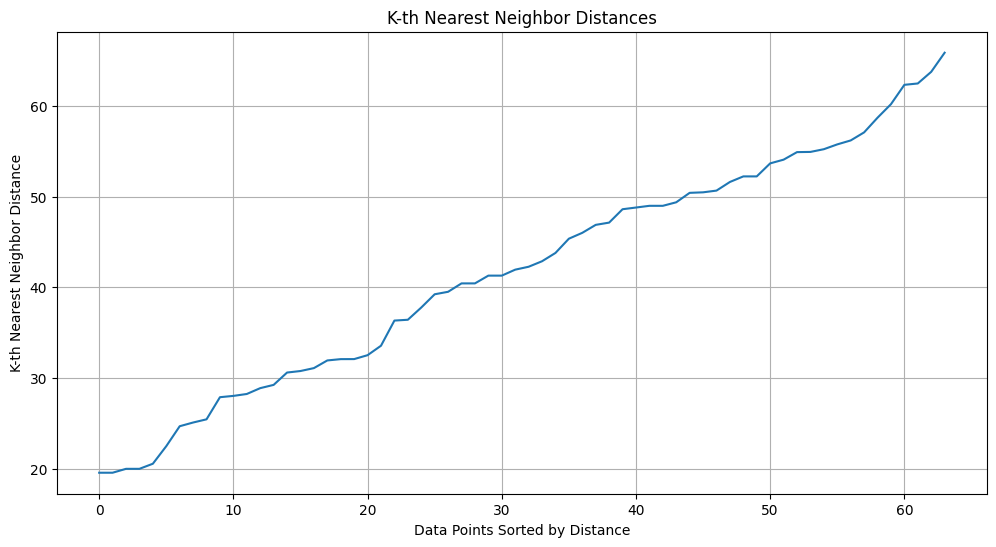

In [3]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=15)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)

distances = np.sort(distances, axis=0)[:, 1]
plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.title("K-th Nearest Neighbor Distances")
plt.xlabel("Data Points Sorted by Distance")
plt.ylabel("K-th Nearest Neighbor Distance")
plt.grid(True)
plt.show()

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_matrix = cosine_similarity(df)

In [5]:
cosine_sim_matrix.max(), cosine_sim_matrix.min()

(1.0000105, 0.00270136)

In [6]:
cosine_sim_matrix = np.clip(cosine_sim_matrix, 0, 1)

In [7]:
cosine_sim_matrix.max(), cosine_sim_matrix.min()

(1.0, 0.00270136)

In [8]:
cosine_dist_matrix = 1 - cosine_sim_matrix
cosine_dist_matrix.max(), cosine_dist_matrix.min()

(0.99729866, 0.0)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(cosine_dist_matrix).astype(np.float64)
data_scaled.max(), data_scaled.min()

(1.5138328075408936, -7.5194621086120605)

In [10]:
data_scaled = data_scaled + abs(data_scaled.min())
data_scaled.max(), data_scaled.min()

(9.033294916152954, 0.0)

In [11]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    cluster_selection_epsilon=0.0,
    metric='precomputed',
    cluster_selection_method='leaf',
    alpha=0.1
)
clusters = clusterer.fit_predict(data_scaled)
clusters_df = pd.DataFrame(clusters, columns=['Cluster'], index=df.index)

In [12]:
# from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps=7, min_samples=1)
# clusters = dbscan.fit_predict(data_scaled)
# clusters_df = pd.DataFrame(clusters, columns=['Cluster'], index=df.index)

In [13]:
pd.DataFrame(clusters, columns=['Cluster'])['Cluster'].value_counts()

Cluster
-1     18
 11    11
 8      8
 10     4
 7      4
 9      3
 2      3
 5      3
 0      2
 6      2
 3      2
 1      2
 4      2
Name: count, dtype: int64

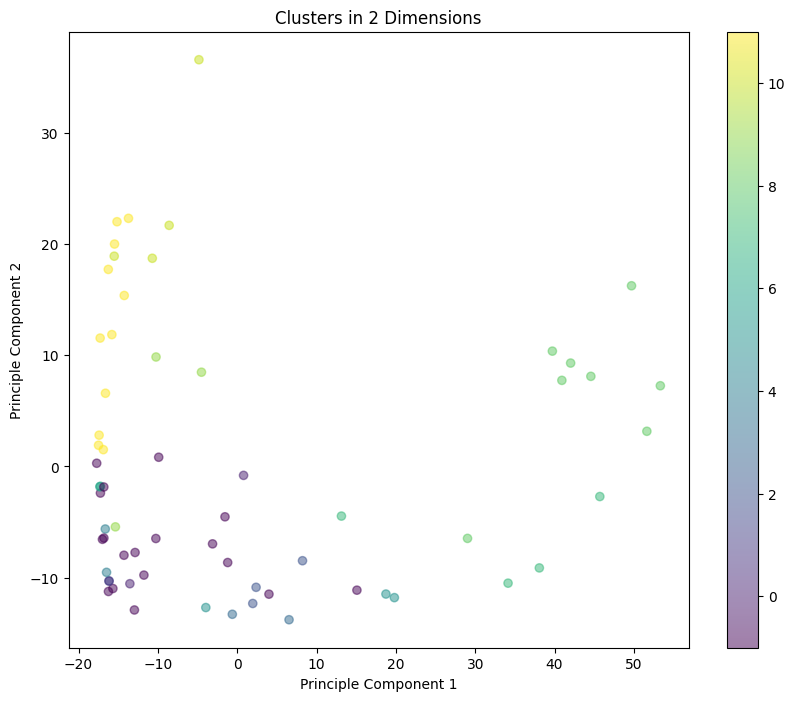

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Clusters in 2 Dimensions')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.colorbar(scatter)
plt.show()

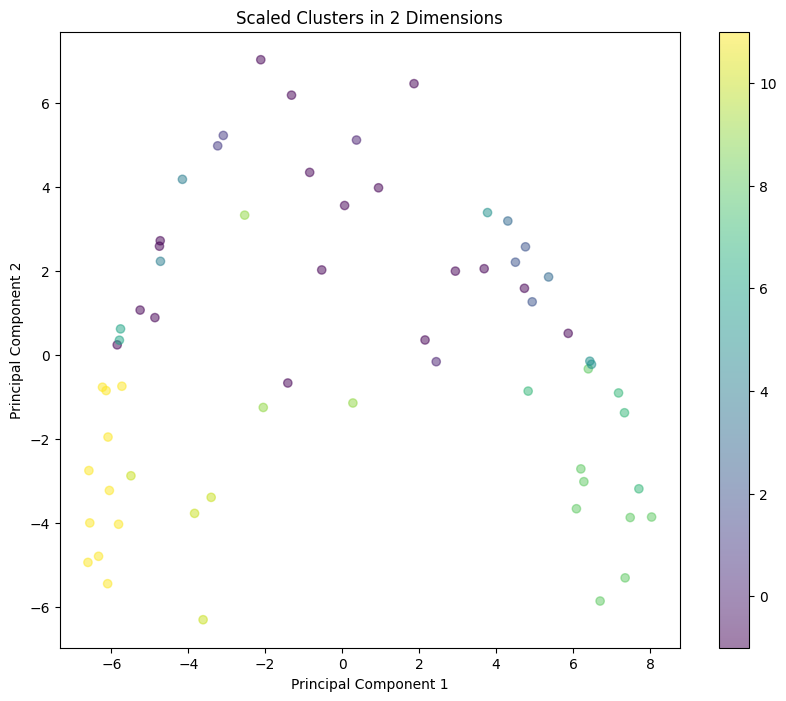

In [17]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Scaled Clusters in 2 Dimensions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()

In [18]:
clusters_df

,Cluster
ECO,
A00,0
A01,0
A02,-1
A04,-1
A10,-1
...,...
E10,4
E11,4
E12,-1


In [21]:
from eco import simplify_eco, eco_decode

clusters_df['ECO'] = clusters_df.index
clusters_df['Opening'] = clusters_df['ECO'].apply(eco_decode)
openings = pd.DataFrame(clusters_df.to_numpy(), columns=['Cluster', 'ECO', 'Opening'])
openings

,Cluster,ECO,Opening
0,0,A00,Polish (Sokolsky) opening
1,0,A01,Nimzovich-Larsen attack
2,-1,A02,Bird's opening
3,-1,A04,Reti opening
4,-1,A10,English opening
...,...,...,...
59,4,E10,Queen's pawn game
60,4,E11,Bogo-Indian defence
61,-1,E12,Queen's Indian defence
62,11,E20,Nimzo-Indian defence


In [31]:
cluster_vals = np.sort(openings['Cluster'].unique())

In [32]:
pd.set_option('display.max_rows', None)

In [36]:
openings[openings['Cluster'] == -1]

,Cluster,ECO,Opening
2,-1,A02,Bird's opening
3,-1,A04,Reti opening
4,-1,A10,English opening
6,-1,A42,"Modern defence, Averbakh system"
9,-1,A47,Queen's Indian defence
11,-1,A50,Queen's pawn game
13,-1,A53,Old Indian defence
14,-1,A56,Benoni defence
27,-1,C21,Centre game
30,-1,C30,King's gambit


In [37]:
openings[openings['Cluster'] == 0]

,Cluster,ECO,Opening
0,0,A00,Polish (Sokolsky) opening
1,0,A01,Nimzovich-Larsen attack


In [38]:
openings[openings['Cluster'] == 1]

,Cluster,ECO,Opening
55,1,D70,Neo-Gruenfeld defence
58,1,E01,"Catalan, closed"


In [39]:
openings[openings['Cluster'] == 2]

,Cluster,ECO,Opening
26,2,C20,King's pawn game
28,2,C23,Bishop's opening
29,2,C25,Vienna game


In [40]:
openings[openings['Cluster'] == 3]

,Cluster,ECO,Opening
36,3,C46,Three knights game
37,3,C47,"Four knights, Scotch variation"


In [41]:
openings[openings['Cluster'] == 4]

,Cluster,ECO,Opening
59,4,E10,Queen's pawn game
60,4,E11,Bogo-Indian defence


In [42]:
openings[openings['Cluster'] == 5]

,Cluster,ECO,Opening
38,5,C50,Italian Game
40,5,C53,Giuoco Piano
41,5,C55,Two knights defence


In [43]:
openings[openings['Cluster'] == 6]

,Cluster,ECO,Opening
15,6,A57,Benko gambit
16,6,A60,Benoni defence


In [44]:
openings[openings['Cluster'] == 7]

,Cluster,ECO,Opening
31,7,C40,King's knight opening
32,7,C41,Philidor's defence
33,7,C42,Petrov's defence
42,7,C60,Ruy Lopez (Spanish opening)


In [45]:
openings[openings['Cluster'] == 8]

,Cluster,ECO,Opening
18,8,B00,King's pawn opening
19,8,B01,Scandinavian (centre counter) defence
20,8,B02,Alekhine's defence
21,8,B06,Robatsch (modern) defence
22,8,B07,Pirc defence
23,8,B10,Caro-Kann defence
24,8,B20,Sicilian defence
25,8,C00,French defence


In [46]:
openings[openings['Cluster'] == 9]

,Cluster,ECO,Opening
8,9,A45,Queen's pawn game
10,9,A48,"King's Indian, East Indian defence"
43,9,D00,Queen's pawn game


In [47]:
openings[openings['Cluster'] == 10]

,Cluster,ECO,Opening
5,10,A40,Queen's pawn
7,10,A43,Old Benoni defence
17,10,A80,Dutch
45,10,D02,Queen's pawn game


In [48]:
openings[openings['Cluster'] == 11]

,Cluster,ECO,Opening
12,11,A51,Budapest defence
48,11,D06,Queen's Gambit
49,11,D07,"Queen's Gambit Declined, Chigorin defence"
50,11,D10,Queen's Gambit Declined Slav defence
51,11,D20,Queen's gambit accepted
52,11,D30,Queen's gambit declined
53,11,D43,Queen's Gambit Declined semi-Slav
54,11,D50,Queen's Gambit Declined
56,11,D80,Gruenfeld defence
62,11,E20,Nimzo-Indian defence


In [51]:
pd.reset_option('display.max_rows')

In [54]:
openings.set_index('ECO', inplace=True)
openings

,Cluster,Opening
ECO,,
A00,0,Polish (Sokolsky) opening
A01,0,Nimzovich-Larsen attack
A02,-1,Bird's opening
A04,-1,Reti opening
A10,-1,English opening
...,...,...
E10,4,Queen's pawn game
E11,4,Bogo-Indian defence
E12,-1,Queen's Indian defence


In [60]:
openings_path = 'openings_clusters.feather'
openings.to_feather(openings_path)